In [6]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [2]:
region = "japan"
catalog = "jma"
mkpath("./results/$region/")

"./results/japan"

In [3]:
df = CSV.read("./catalogs/$catalog.csv", DataFrame);
first(df,5)

Row,Datetime,Latitude,Longitude,Depth,Magnitude,Magnitude_type
,DateTime,Float64,Float64,Float64,Float64,String1
1,1983-01-01T00:36:05.840,33.0778,139.035,0.21,3.9,V
2,1983-01-01T00:44:03.730,33.0892,139.042,0.0,3.2,V
3,1983-01-01T01:05:05.160,33.0918,139.044,0.17,3.7,V
4,1983-01-01T01:18:05.400,33.078,139.041,0.16,2.8,V
5,1983-01-01T01:21:05.440,33.0798,139.034,0.09,2.9,V


In [4]:
# Using describe function to get statistics of a dataset
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Datetime,,1983-01-01T00:36:05.840,2011-04-13T18:59:57.415,2020-08-31T23:55:49.130,0,DateTime
2,Latitude,35.4498,17.4093,35.6292,50.4268,0,Float64
3,Longitude,136.999,118.905,138.574,156.681,0,Float64
4,Depth,22.4566,0.0,11.27,698.4,0,Float64
5,Magnitude,1.31486,0.1,1.1,9.0,0,Float64
6,Magnitude_type,,D,,v,0,String1


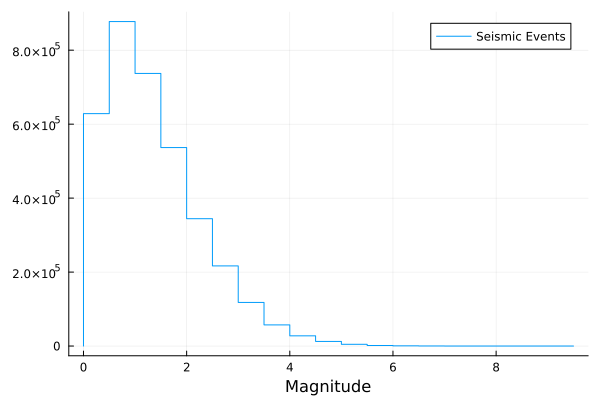

In [7]:
fig = Plots.histogram(df[:,:Magnitude],
                    bins = 40, xlabel = "Magnitude", label="Seismic Events")

savefig("./results/$region/histogram_events_magnitudes.png")
fig

In [8]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end

join_on_counted_no_mag_bounds (generic function with 1 method)

In [9]:
function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [12]:
year(minimum(df.Datetime))

1983

In [13]:
trim_year = year(minimum(df.Datetime))
magnitude_threshold = 0.0;

In [14]:
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

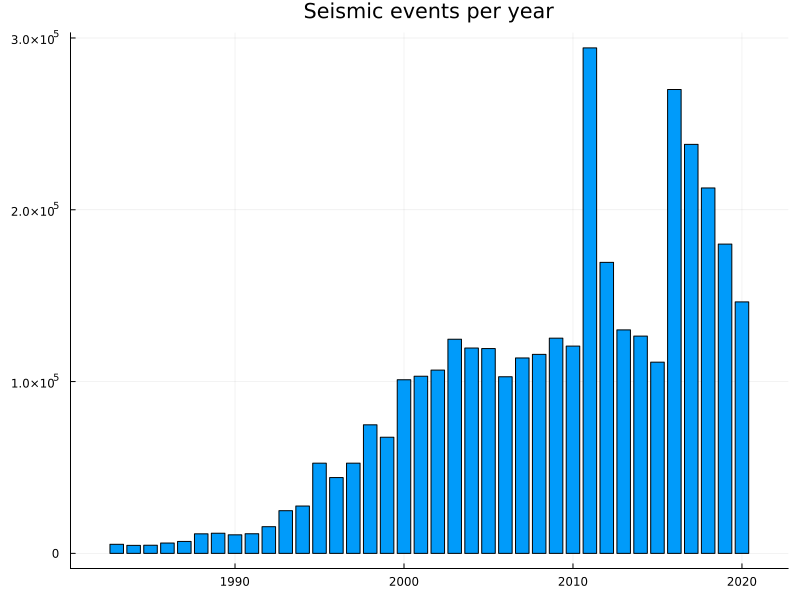

In [15]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

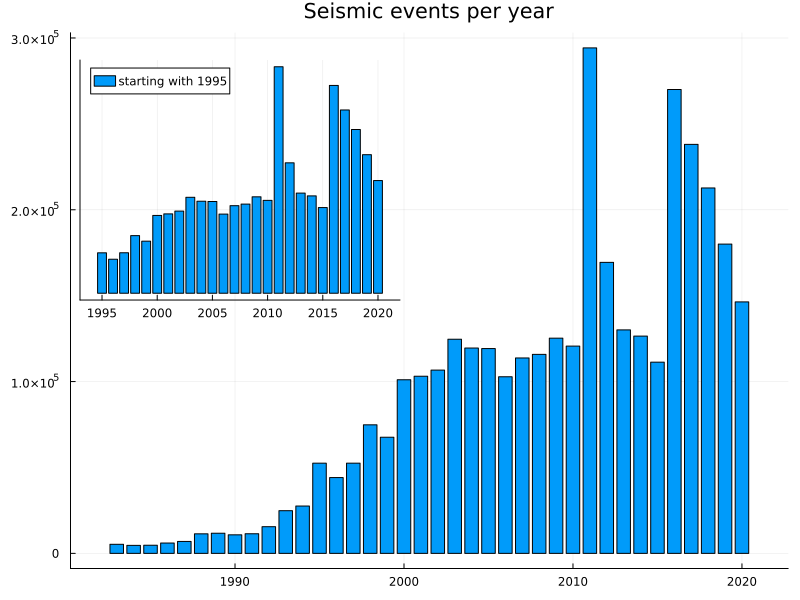

In [23]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

cutoff=25
# Inset plot
# Select from 1976 onwards 
bar!(df_counted.Year[end-cutoff:end], df_counted.count[end-cutoff:end], 
	orientation=:vertical,
    inset = bbox(0.1, 0.1, 0.4, 0.4, :top, :left), 
    label="starting with $(df_counted.Year[end-cutoff:end][1])",
    # ticks = nothing,
    yticks = nothing,
    subplot = 2,
    bg_inside = nothing)
	# label="Seismic Events")


savefig("./results/$region/events_per_year.png")
fig

In [ ]:
trim_year = 1995
df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)),:];

# Make directory if it does not exist
mkpath("./data/")

# Write to CSV
CSV.write("./data/$region.csv", df_trimmed)